In [157]:

%env JAX_ENABLE_X64=1
import numpy as onp

# from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax

import time

from jax_md import space
from jax_md import smap
from jax_md import energy
from jax_md import quantity
from jax_md import simulate
from jax_md import partition

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')
plt.style.use('tableau-colorblind10')
def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

env: JAX_ENABLE_X64=1


In [2]:
Nx = particles_per_side = 20
spacing = np.float32(1.25)
side_length = Nx * spacing

R = onp.stack([onp.array(r) for r in onp.ndindex(Nx, Nx)]) * spacing
R = np.array(R, np.float64)

In [3]:
# state

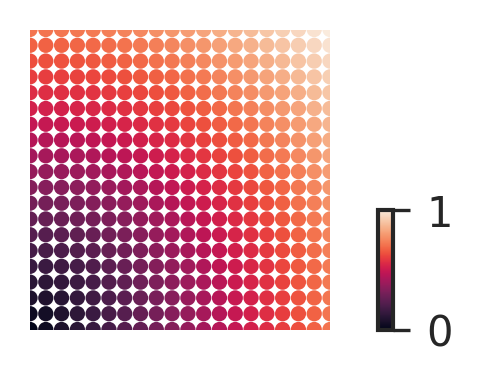

In [158]:
#@title Draw the initial state
ms = 1
R_plt = onp.array(R)

def rplot(ax, R_plt, ms=0.7, colors="red",cmap=None):
    ax.scatter(R_plt[:, 0], R_plt[:, 1], s=ms,  
            alpha=1,c=colors,cmap=cmap)
    
    ax.set_xlim([0, np.max(R[:, 0])])
    ax.set_ylim([0, np.max(R[:, 1])])
    
    ax.axis('off')
    
    # return finalize_plot((2, 2))
    return ax

import patchworklib as pw

   
ax1 = rplot(pw.Brick(), R_plt, ms=10, colors=np.linalg.norm(R_plt,axis=-1))   
ax1.add_colorbar()

In [5]:
# format = partition.Dense
# format = partition.Sparse
format = partition.OrderedSparse

In [6]:

displacement, shift = space.periodic(side_length)

neighbor_fn, energy_fn = energy.lennard_jones_neighbor_list(displacement, 
                                                            side_length,
                                                            format=format)
energy_fn = jit(energy_fn)

exact_energy_fn = jit(energy.lennard_jones_pair(displacement))

In [7]:
nbrs = neighbor_fn.allocate(R)

In [8]:

# Run once so that we avoid the jit compilation time.
print('E = {}'.format(energy_fn(R, neighbor=nbrs)))
print('E_ex = {}'.format(exact_energy_fn(R)))

E = -720.3801006080002
E_ex = -720.3801006080002


In [9]:

displacement, shift = space.periodic(side_length)

init_fn, apply_fn = simulate.nve(energy_fn, shift, 1e-3)
state = init_fn(random.PRNGKey(0), R, kT=1e-3, neighbor=nbrs)

def body_fn(i, state):
  state, nbrs = state
  nbrs = nbrs.update(state.position)
  state = apply_fn(state, neighbor=nbrs)
  return state, nbrs

all_states = []
NSTEP = 10_000
MAXSTEPS = NSTEP
step = 0
while step < MAXSTEPS:
  new_state, nbrs = lax.fori_loop(0, 100, body_fn, (state, nbrs))
  if nbrs.did_buffer_overflow:
    print('Neighbor list overflowed, reallocating.')
    nbrs = neighbor_fn.allocate(state.position)
  else:
    all_states.append(state)
    state = new_state
    step += 1

    

Neighbor list overflowed, reallocating.


In [10]:
len(all_states)

10000

In [167]:
#@title Draw the final state
ms = 10
timepoints = [0,   2490,   4990, 7490, 9981]
# r_plts = [onp.array(all_states[i].position) for i in timepoints]
# f_plts = [onp.array(all_states[i].force) for i in timepoints]
# p_plts = [onp.array(all_states[i].momentum) for i in timepoints]

bricks_to_plot = lambda: [pw.Brick() for i in timepoints]

r_plts = bricks_to_plot()
r_plts_ = []
positions = []
for i, brick in enumerate(r_plts):
    i_ = timepoints[i]
    i_ += 1
    brick = rplot(brick, onp.array(all_states[i_].position))
    brick.set_title(f"$t$ = {i_}")
    r_plts_.append(brick)
    positions.append(onp.array(all_states[i_].position))
    
p_plts = bricks_to_plot()
for i, brick in enumerate(p_plts):
    i_ = timepoints[i]
    i_ += 1
    brick.hist(onp.array(all_states[i_].momentum))
    # brick.set_ylim(0, 200)
    brick.set_xlim(-2,2)
    
f_plts = bricks_to_plot()
for i, brick in enumerate(f_plts):
    i_ = timepoints[i]
    i_ += 1
    brick.hist(onp.array(all_states[i_].force))
    # brick.set_ylim(0, 200 )
    brick.set_xlim(-30,30)

    

In [168]:
energies = [exact_energy_fn(R) for R in [onp.array(all_states[i].position) for i in range(NSTEP)]]

In [169]:
energies = np.array(energies)
energies = energies - energies.mean()

In [170]:
ax = pw.Brick(figsize=(4,0.71))
ax.plot(energies)
FS=14
ax.set_xlabel("$t$", fontsize=FS)
ax.set_ylabel("$E$", fontsize=FS)
# ax

Text(-38.66666666666667, 0.5, '$E$')

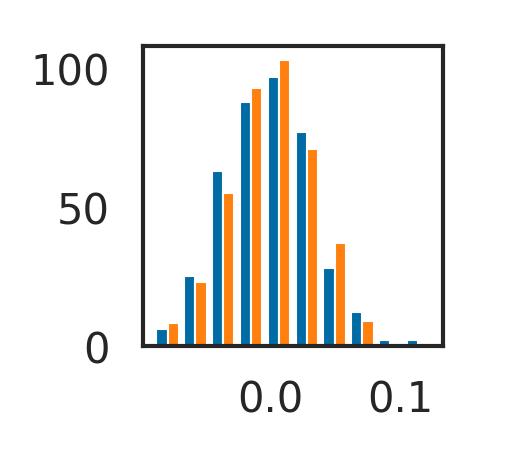

In [171]:

brick = pw.Brick()
brick.hist(onp.array(all_states[0].momentum))
brick


In [172]:
all_R = [all_states[i].position for i in range(NSTEP)]
all_Fm = [onp.linalg.norm(all_states[i].force[0]) for i in range(NSTEP)]

In [173]:
all_R_stack = np.stack(all_R)
all_Fm_stack = np.stack(all_Fm)

In [174]:
all_R_stack.shape, all_Fm_stack.shape

((10000, 400, 2), (10000,))

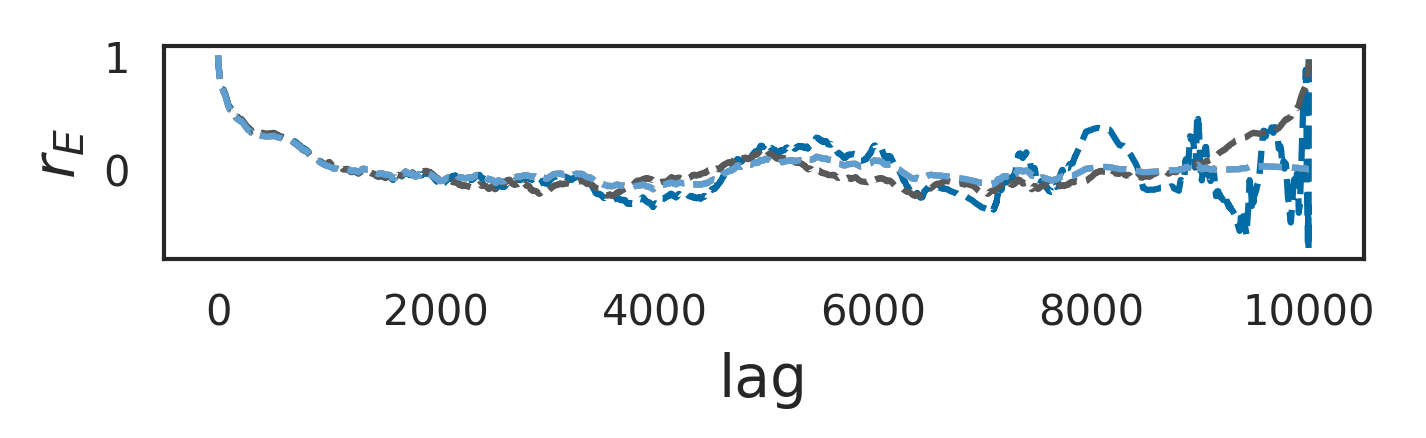

In [175]:
import numpy
import matplotlib.pyplot as plt

def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

def autocorr2(x,lags):
    '''manualy compute, non partial'''

    mean=numpy.mean(x)
    var=numpy.var(x)
    xp=x-mean
    corr=[1. if l==0 else numpy.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return numpy.array(corr)

def autocorr3(x,lags):
    '''fft, pad 0s, non partial'''

    n=len(x)
    # pad 0s to 2n-1
    ext_size=2*n-1
    # nearest power of 2
    fsize=2**numpy.ceil(numpy.log2(ext_size)).astype('int')

    xp=x-numpy.mean(x)
    var=numpy.var(x)

    # do fft and ifft
    cf=numpy.fft.fft(xp,fsize)
    sf=cf.conjugate()*cf
    corr=numpy.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]

def autocorr4(x,lags):
    '''fft, don't pad 0s, non partial'''
    mean=x.mean()
    var=numpy.var(x)
    xp=x-mean

    cf=numpy.fft.fft(xp)
    sf=cf.conjugate()*cf
    corr=numpy.fft.ifft(sf).real/var/len(x)

    return corr[:len(lags)]

def autocorr5(x,lags):
    '''numpy.correlate, non partial'''
    mean=x.mean()
    var=numpy.var(x)
    xp=x-mean
    corr=numpy.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]




axE = pw.Brick(figsize=(4,0.71))

for i in range(1):
    y=np.linalg.norm(all_R_stack[:,0],axis=-1)
    y=numpy.array(y).astype('float')
    lags=range(NSTEP)
    

    for funcii, labelii in zip([autocorr1, autocorr2, autocorr3, autocorr4,
        autocorr5], ['np.corrcoef, partial', 'manual, non-partial',
            'fft, pad 0s, non-partial', 'fft, no padding, non-partial',
            'np.correlate, non-partial']):

        cii=funcii(y,lags)      
        if i == 0:
            axE.plot(lags,cii,label=labelii, linestyle="--")
        else:
            axE.plot(lags,cii,label=labelii)

    
    # axE.set_ylabel('cor. coef. $r$')
    # axE.legend()
    # plt.show()
axE.set_ylabel('$r_E$', fontsize=FS)
axE.set_xlabel('lag', fontsize=FS)
axE

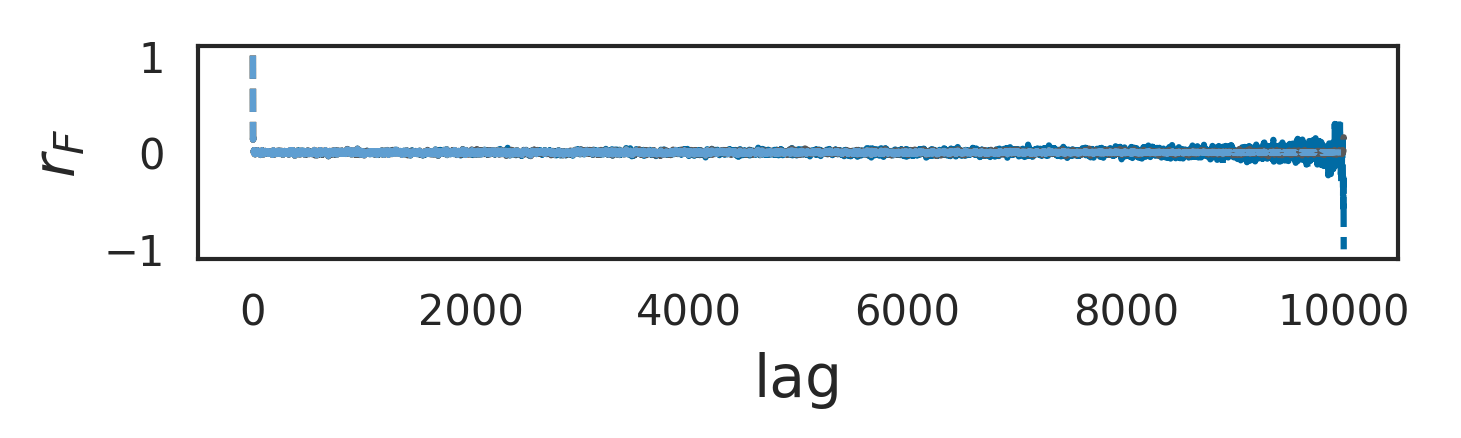

In [176]:
axF = pw.Brick(figsize=(4,0.71))


y=all_Fm_stack
y=numpy.array(y).astype('float')
lags=range(NSTEP)


for funcii, labelii in zip([autocorr1, autocorr2, autocorr3, autocorr4,
    autocorr5], ['np.corrcoef, partial', 'manual, non-partial',
        'fft, pad 0s, non-partial', 'fft, no padding, non-partial',
        'np.correlate, non-partial']):

    cii=funcii(y,lags)      
    if i == 0:
        axF.plot(lags,cii,label=labelii, linestyle="--")
    else:
        axF.plot(lags,cii,label=labelii)

axF.set_xlabel('lag', fontsize=FS)
axF.set_ylabel('$r_F$', fontsize=FS)
# axF.legend()
axF

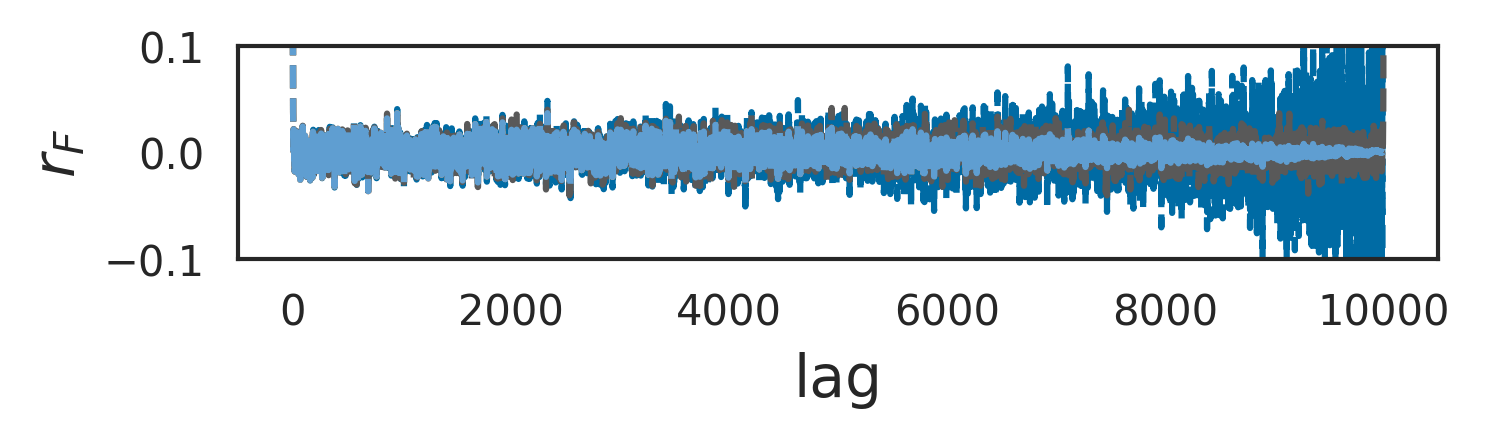

In [177]:
axF.set_ylim(-0.1,0.1)
axF

In [178]:
fig =  (pw.stack(r_plts_) / pw.stack(p_plts) / pw.stack(f_plts)) / (ax / axE / axF) 

In [179]:
fig.change_plotsize((7,5))

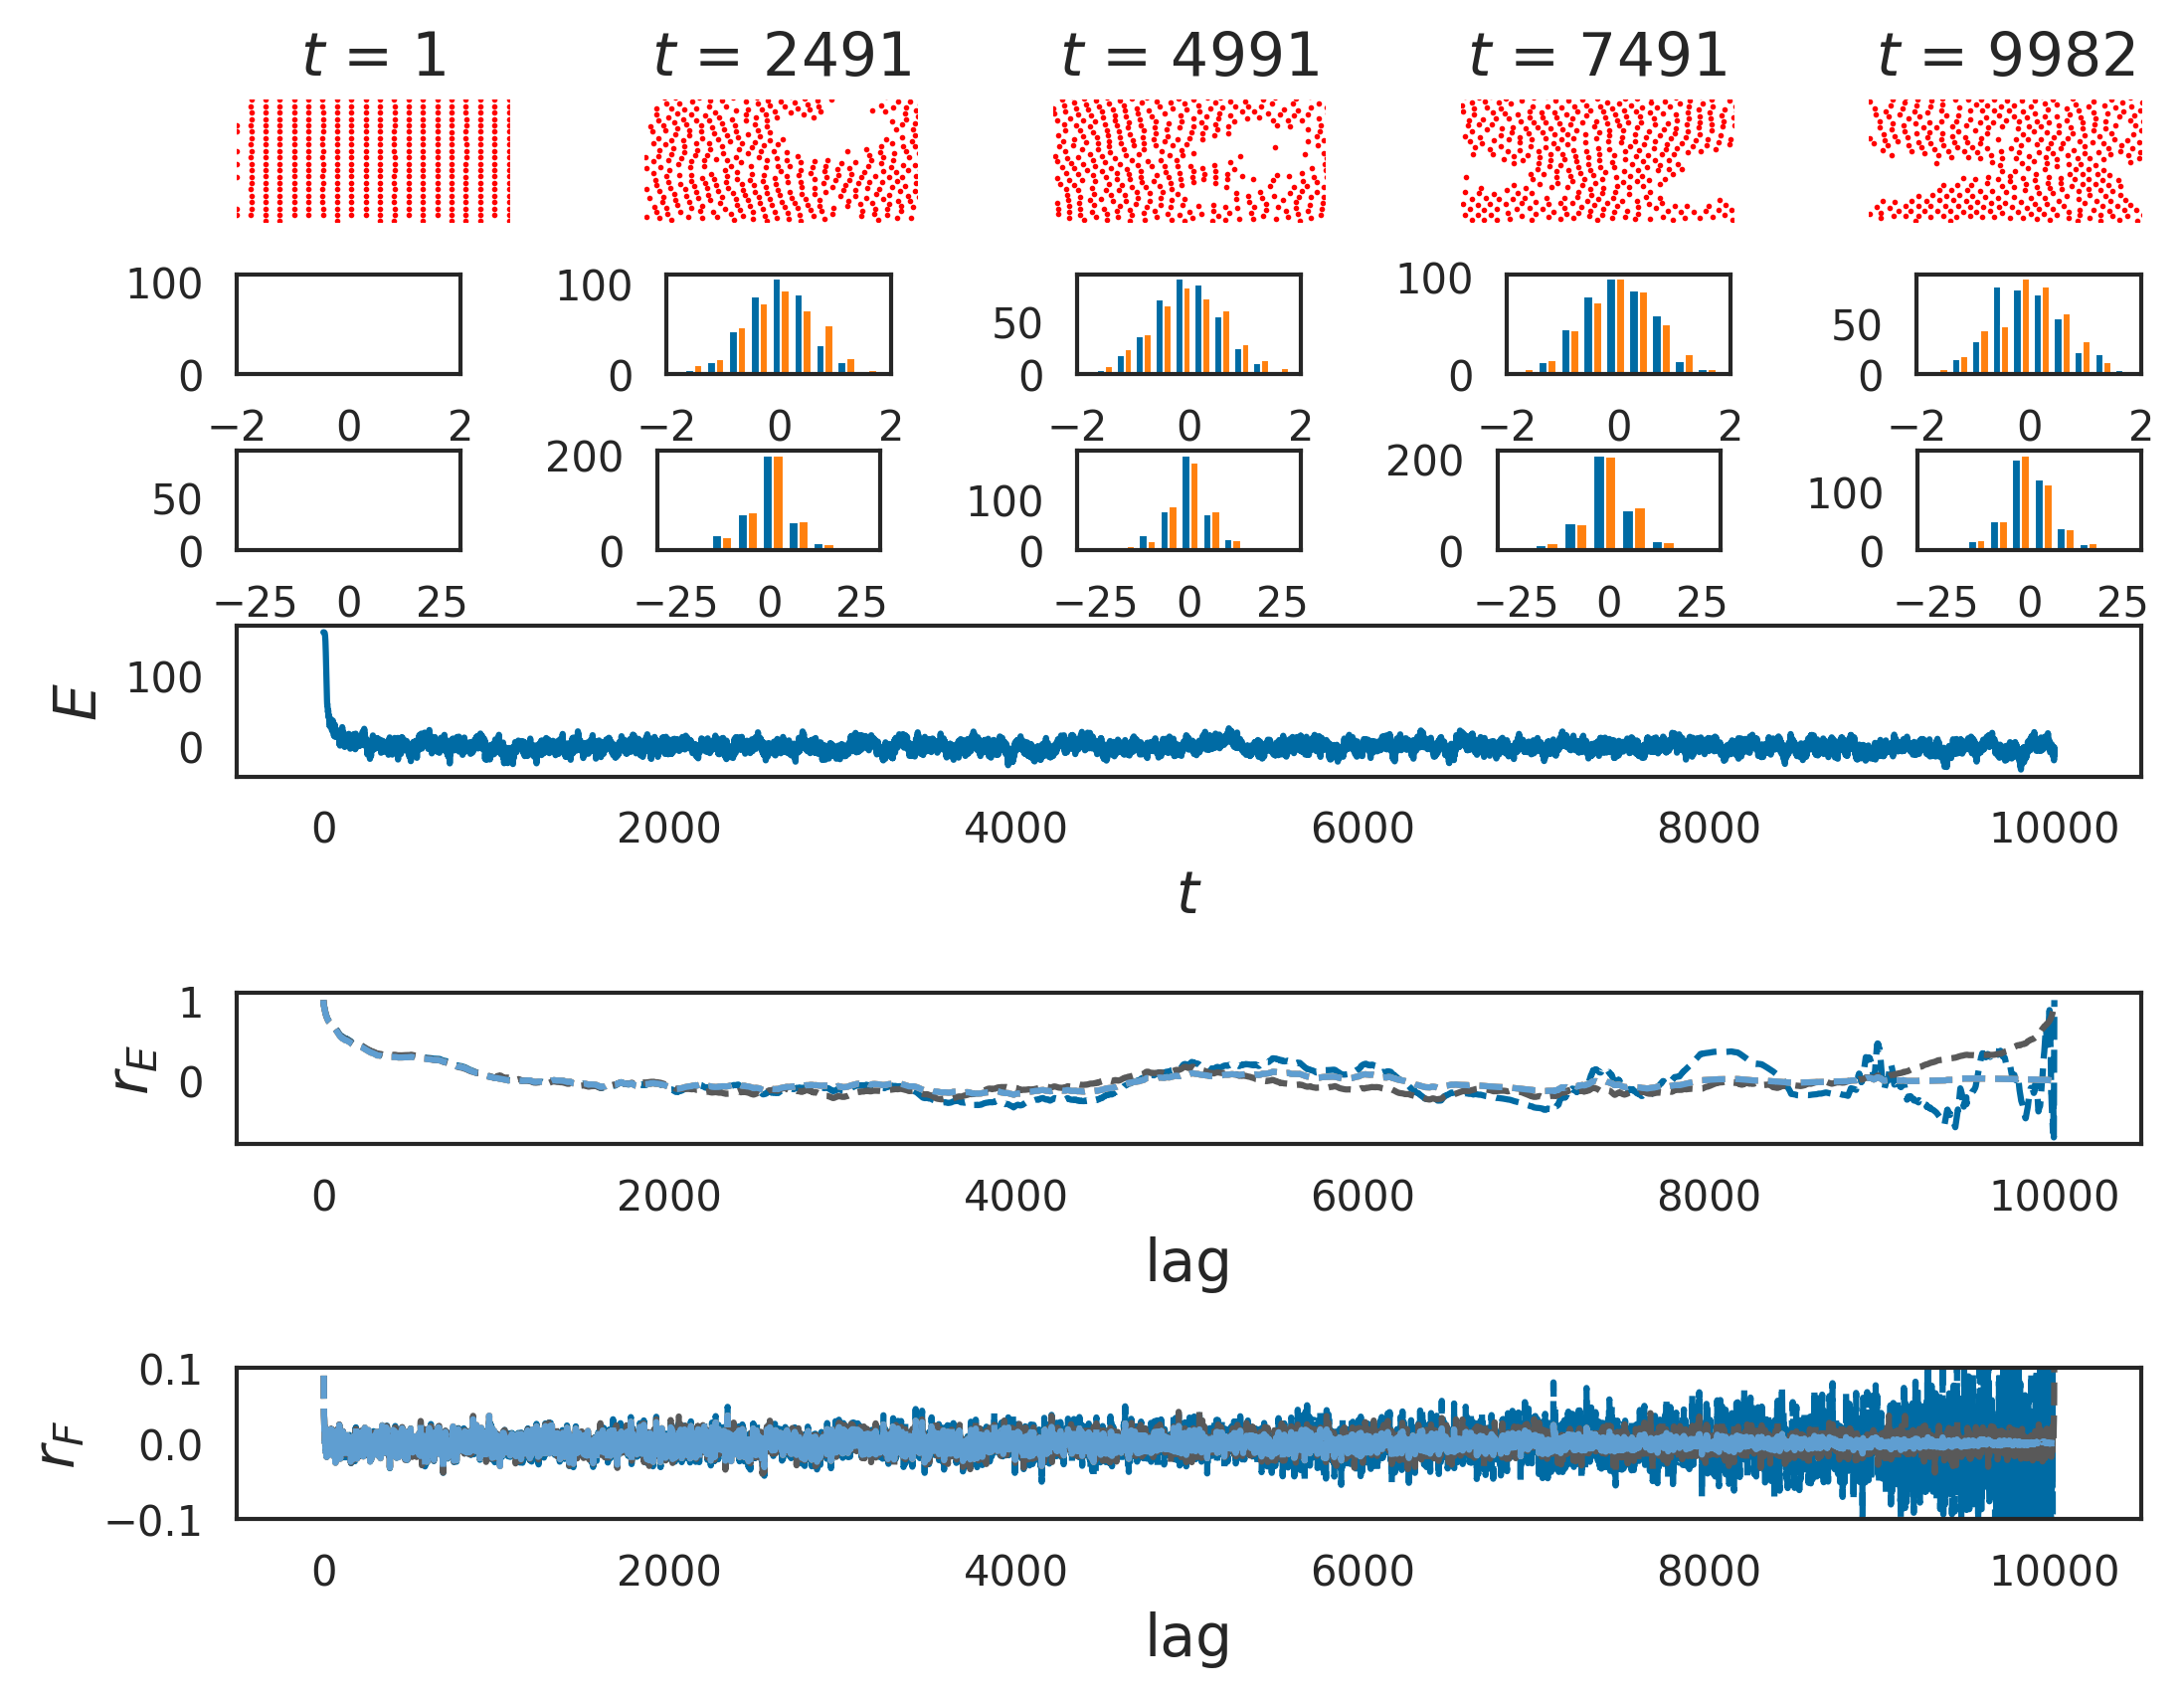

In [180]:
fig

In [181]:
np.array(positions).shape

(5, 400, 2)

In [182]:
import MDAnalysis as mda

In [183]:
! uv pip install chemtrain

Audited 1 package in 38ms


In [184]:
! uv pip install freud-analysis

Audited 1 package in 4ms


In [185]:
ALLXYZ = np.stack([ onp.array(all_states[i_].position) for _i in range(len(all_states))])

In [82]:
import freud
rdf = freud.density.RDF(bins=50, r_max=5)

In [83]:
box = freud.box.Box(Lx=side_length, Ly=side_length, is2D=True)
box

freud.box.Box(Lx=25.0, Ly=25.0, Lz=0.0, xy=0.0, xz=0.0, yz=0.0, is2D=True)

In [143]:
ALLXYZ.shape

(10000, 400, 2)

In [144]:
traj = positions
for frame_positions in ALLXYZ[:100]:
    XYZ = onp.array( [np.zeros_like(frame_positions[:,0]) for i in range(3)]).T
    XYZ[:,:2] = frame_positions
    rdf.compute(system=(box, XYZ), reset=False)

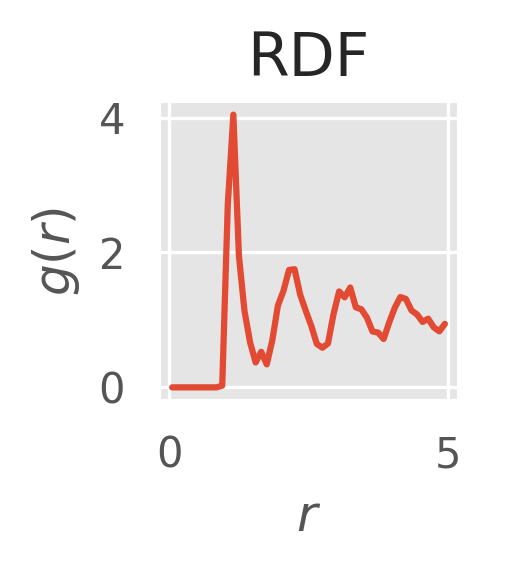

In [145]:
ax_rdf = pw.Brick()
rdf.plot(ax=ax_rdf)
ax_rdf

In [151]:
ld = freud.density.LocalDensity(r_max=5, diameter=0.05)

In [191]:
if ld == None:
    ld = freud.density.LocalDensity(r_max=5, diameter=0.05)
LD = ld.compute(system=(box, XYZ))
ax1 = rplot(pw.Brick(), XYZ,colors=LD.density,cmap="cividis_r")  

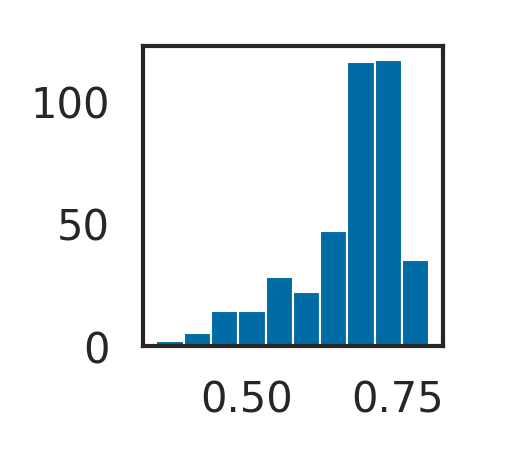

In [194]:
ld_ax = pw.Brick()
ld_ax.hist(LD.density)
ld_ax

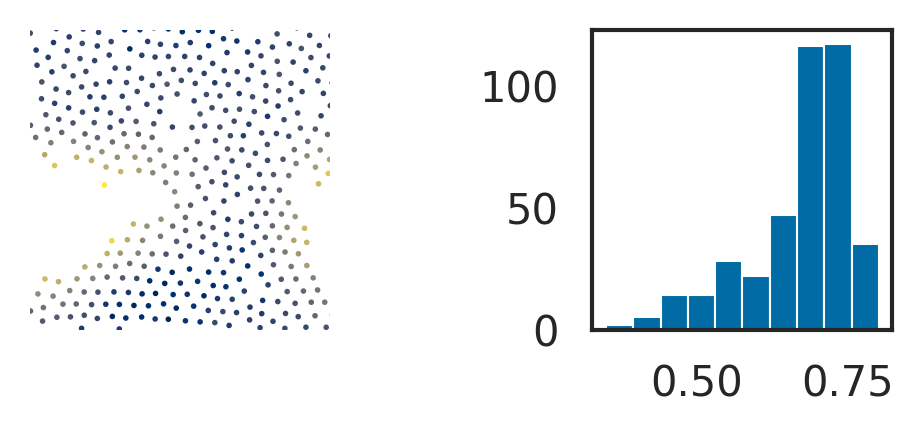

In [195]:
ax1
ax1.add_colorbar(cmap="cividis_r")
ax1 | ld_ax

In [196]:
# import matplotlib.pyplot as plt
# import numpy as np

# import matplotlib.animation as animation
# fig, ax = plt.subplots()
# rng = onp.random.default_rng(19680801)
# data = np.array([20, 20, 20, 20])
# x = np.array([1, 2, 3, 4])

# artists = []
# colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple']
# for i in range(20):
#     data += rng.integers(low=0, high=10, size=data.shape)
#     container = ax.barh(x, data, color=colors)
#     artists.append(container)


# ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
# plt.show()
# # ani